# Lung and Colon Cancer Histopathological Images classification

import library

In [4]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os, fnmatch
import cv2
from tqdm.notebook import tqdm
from time import sleep
from numpy.random import seed
from pathlib import Path
from PIL import Image
import seaborn as sns
%matplotlib inline

Create supplyment function

In [5]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
# **** UPDATE ****
# Change from lastes to Highest Accuracy
def show_result(history): 
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['acc']
    temp_vloss = temph['val_acc']
    temp_vacc = temph['val_acc']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index

    # Print the result from the Highest val_acc epoch
    print('Highest validation accuracy in Epoch: %s'%str(max_index+1))
    print('Train accuracy: %s'%temp_acc[max_index])
    print('Validation accuracy: %s'%temp_vacc[max_index])

    print('--------------------------------------------------')
    
    # Print the result from the last epoch
    print('Last train Epoch')
    print('Train accuracy: %s'%history.history['acc'][-1])
    print('Validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size, row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

directory function

In [7]:
# change sub directory in list
def dirToList(dir_path):
    #get path create list
    pth = os.listdir(path=dir_path)
    lst_dir = []

    for s in pth:
        temp = str(dir_path + '/' + s + '/')
        lst_dir.append(temp)

    return lst_dir

# map path to name
def mapName(lab_list, lab_dict):
    temp = []
    for i in tqdm(range(len(lab_list))):
        key_label = lab_dict[lab_list[i]]
        temp.append(key_label)
    return temp

## Import data

Get Root folders

In [17]:
lung_dir = dirToList('lung_colon_image_set/lung_image_sets')
colon_dir = dirToList('lung_colon_image_set/colon_image_sets')
root_dir = lung_dir[1:] + colon_dir[1:]
print(root_dir)

['lung_colon_image_set/lung_image_sets/lung_aca/', 'lung_colon_image_set/lung_image_sets/lung_n/', 'lung_colon_image_set/lung_image_sets/lung_scc/', 'lung_colon_image_set/colon_image_sets/colon_n/', 'lung_colon_image_set/colon_image_sets/colon_aca/']


Get path file to dataframe

In [23]:
lung_aca_path = list(Path(root_dir[0]).glob(r'**/*.jpeg'))
lung_n_path = list(Path(root_dir[1]).glob(r'**/*.jpeg'))
lung_scc_path = list(Path(root_dir[2]).glob(r'**/*.jpeg'))
colon_n_path = list(Path(root_dir[3]).glob(r'**/*.jpeg'))
colon_aca_path = list(Path(root_dir[4]).glob(r'**/*.jpeg'))

In [26]:
lung_aca_df = pd.DataFrame(lung_aca_path, columns=['path'])
lung_aca_df['label'] = 'lung_aca'
lung_n_df = pd.DataFrame(lung_n_path, columns=['path'])
lung_n_df['label'] = 'lung_n'
lung_scc_df = pd.DataFrame(lung_scc_path, columns=['path'])
lung_scc_df['label'] = 'lung_scc'
colon_n_df = pd.DataFrame(colon_n_path, columns=['path'])
colon_n_df['label'] = 'colon_n'
colon_aca_df = pd.DataFrame(colon_aca_path, columns=['path'])
colon_aca_df['label'] = 'colon_aca'

Train Test (validation) Split

In [27]:
# Test size = 20%
lung_aca_Tr, lung_aca_te = train_test_split(lung_aca_df, test_size=0.2, random_state=42)
lung_n_Tr, lung_n_te = train_test_split(lung_n_df, test_size=0.2, random_state=42)
lung_scc_Tr, lung_scc_te = train_test_split(lung_scc_df, test_size=0.2, random_state=42)
colon_n_Tr, colon_n_te = train_test_split(colon_n_df, test_size=0.2, random_state=42)
colon_aca_Tr, colon_aca_te = train_test_split(colon_aca_df, test_size=0.2, random_state=42)

In [28]:
# Validation size = 10%, Train size = 70%
lung_aca_tr, lung_aca_va = train_test_split(lung_aca_Tr, test_size=0.1, random_state=42)
lung_n_tr, lung_n_va = train_test_split(lung_n_Tr, test_size=0.1, random_state=42)
lung_scc_tr, lung_scc_va = train_test_split(lung_scc_Tr, test_size=0.1, random_state=42)
colon_n_tr, colon_n_va = train_test_split(colon_n_Tr, test_size=0.1, random_state=42)
colon_aca_tr, colon_aca_va = train_test_split(colon_aca_Tr, test_size=0.1, random_state=42)

Merge to single dataset

In [40]:
train_df = pd.concat([lung_aca_tr, lung_n_tr, lung_scc_tr, colon_n_tr, colon_aca_tr])
train_df['path'] = train_df['path'].astype(str)
print(train_df.shape)
train_df.head(10)

(18000, 2)


,path,label
3489,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
948,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
2132,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
4316,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
4599,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
945,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
3833,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
1328,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
1544,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
2015,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca


In [41]:
test_df = pd.concat([lung_aca_te, lung_n_te, lung_scc_te, colon_n_te, colon_aca_te])
test_df['path'] = test_df['path'].astype(str)
print(test_df.shape)
test_df.head(10)

(5000, 2)


,path,label
1501,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
2586,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
2653,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
1055,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
705,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
106,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
589,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
2468,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
2413,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
1600,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca


In [42]:
val_df = pd.concat([lung_aca_va, lung_n_va, lung_scc_va, colon_n_va, colon_aca_va])
val_df['path'] = val_df['path'].astype(str)
print(val_df.shape)
val_df.head(10)

(2000, 2)


,path,label
682,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
4312,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
647,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
878,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
777,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
2673,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
1423,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
1438,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
618,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca
4914,lung_colon_image_set/lung_image_sets/lung_aca/...,lung_aca


## Convolutional Neural Network

### Load Dataset & Preprocessing

create image generator

In [43]:
#create preset of image generator
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.4,1.5],
    zoom_range = 0.3,
    fill_mode = 'reflect'
)

validate_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)


test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

Parameter setup

In [44]:
X_COL = 'path'
Y_COL = 'label'
MODE = 'rgb'
BATCH_SIZE = 16

In [46]:
#load data by flow_from_dataframe
train_ds = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

val_ds = validate_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = (224, 224),
    color_mode = MODE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 18000 validated image filenames belonging to 5 classes.
Found 2000 validated image filenames belonging to 5 classes.
Found 5000 validated image filenames belonging to 5 classes.


### Build a convolutional neural network

Transfer learning

In [47]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [53]:
def def_model():
    model = InceptionResNetV2(
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
    full_conn = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(5, activation='sigmoid')(full_conn)
	# define new model
    model = Model(inputs=model.inputs, outputs=output)
	# compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.save('model/InceptionResNetV2.h5')
    model.summary()
    return model


In [54]:
irnv2 = def_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_406 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_406 (Batch  (None, 111, 111, 32  96         ['conv2d_406[0][0]']             
 Normalization)                 )                                                           

In [55]:
save_path = 'weight_improvement/irnv2_x224_{epoch:02d}_{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(save_path, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

history3 = irnv2.fit(
    train_ds, 
    batch_size=16,
    epochs=100,
    validation_data=(val_ds),
    callbacks = callbacks_list
)
irnv2.save('model/InceptionResNetV2_x224_itr100.h5')

Epoch 1/100


2022-11-09 23:37:36.310263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1125/1125 [==============================] - ETA: 0s - loss: 0.9563 - acc: 0.8195

2022-11-09 23:41:28.811646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.92250, saving model to weight_improvement/irnv2_x224_01_0.92.hdf5
1125/1125 [==============================] - 271s 233ms/step - loss: 0.9563 - acc: 0.8195 - val_loss: 0.1844 - val_acc: 0.9225
Epoch 2/100
1125/1125 [==============================] - ETA: 0s - loss: 0.2841 - acc: 0.8928
Epoch 2: val_acc improved from 0.92250 to 0.92500, saving model to weight_improvement/irnv2_x224_02_0.93.hdf5
1125/1125 [==============================] - 327s 291ms/step - loss: 0.2841 - acc: 0.8928 - val_loss: 0.2206 - val_acc: 0.9250
Epoch 3/100
1125/1125 [==============================] - ETA: 0s - loss: 0.2321 - acc: 0.9151
Epoch 3: val_acc improved from 0.92500 to 0.94750, saving model to weight_improvement/irnv2_x224_03_0.95.hdf5
1125/1125 [==============================] - 325s 289ms/step - loss: 0.2321 - acc: 0.9151 - val_loss: 0.1619 - val_acc: 0.9475
Epoch 4/100
1125/1125 [==============================] - ETA: 0s - loss: 0.2225 - acc: 0.9213
Epoch 4: 

Highest validation accuracy in Epoch: 93
Train accuracy: 0.9727222323417664
Validation accuracy: 0.9920000433921814
--------------------------------------------------
Last train Epoch
Train accuracy: 0.9711111187934875
Validation accuracy: 0.9865000247955322


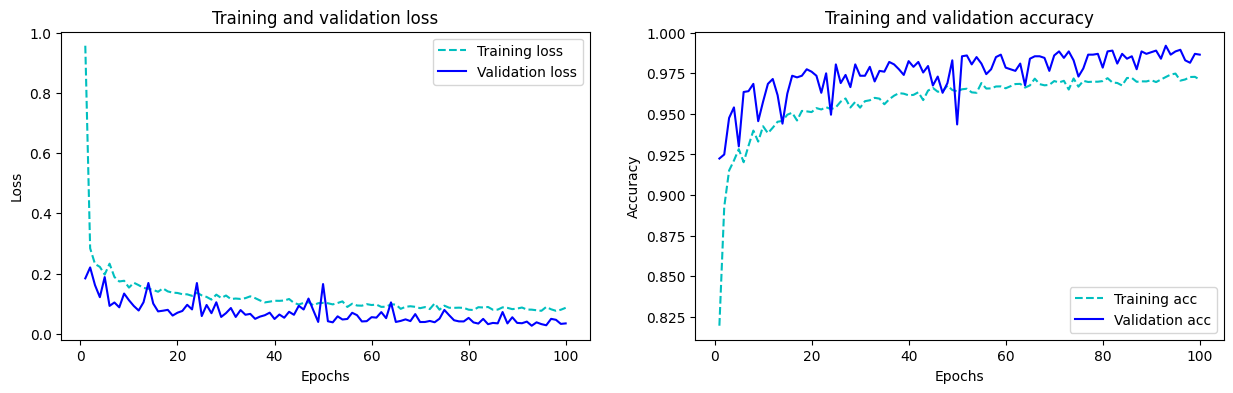

In [56]:
show_result(history3)

### Evaluation

Last epoch

In [57]:
result = irnv2.evaluate(test_ds, verbose=0)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}".format(result[1]))

Test loss: 0.03346
Test accuracy: 0.99


weight improvement

In [58]:
model = load_model('weight_improvement/irnv2_x224_93_0.99.hdf5')

result = model.evaluate(test_ds, verbose=0)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}".format(result[1]))

2022-11-10 09:37:40.180545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.02684
Test accuracy: 0.99
